# Customer Segmentation — Step by Step (Mall Customers)


In [5]:
# 1) Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")


In [6]:
# 2) Load Data
# Update this path if your CSV is elsewhere
data_path = r"C:\Users\Admin\Downloads\Guvi\Project\Projects List\Final Projects\Customer Segmentation\Final Project 2 Mall Customer Dataset.csv"
df = pd.read_csv(data_path)
print(df.shape)
df.head()


(200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [15]:
# 3) EDA
display(df.info())
display(df.describe(include='all').T)
print("\nMissing values per column:")
print(df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CustomerID,200.0,NaN,NaN,NaN,100.5,57.879185,1.0,50.75,100.5,150.25,200.0
Gender,200,2,Female,112,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,200.0,NaN,NaN,NaN,38.85,13.969007,18.0,28.75,36.0,49.0,70.0
Annual Income (k$),200.0,NaN,NaN,NaN,60.56,26.264721,15.0,41.5,61.5,78.0,137.0
Spending Score (1-100),200.0,NaN,NaN,NaN,50.2,25.823522,1.0,34.75,50.0,73.0,99.0



Missing values per column:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


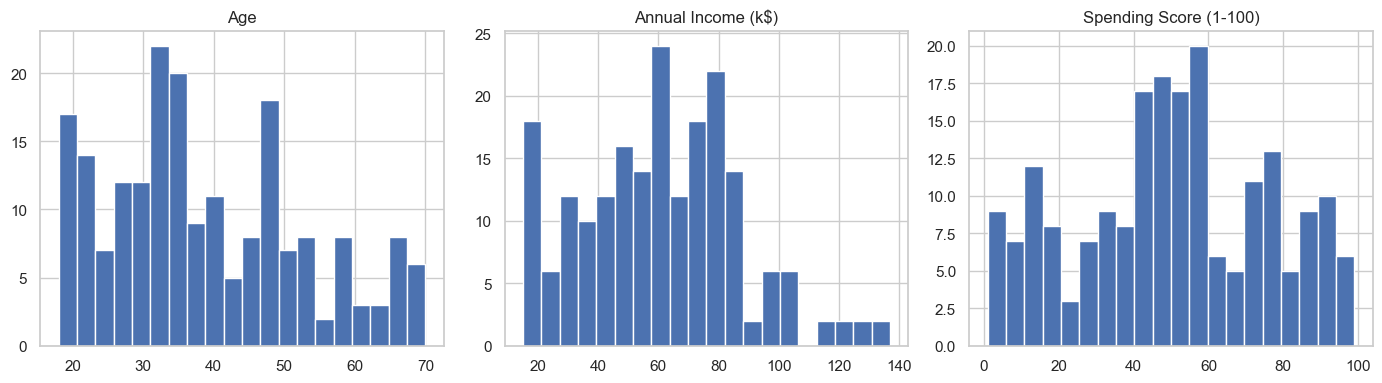

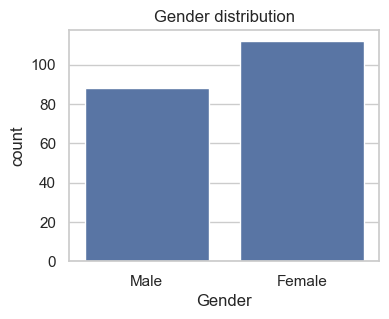

In [16]:
# 4) Visualisation
fig, axes = plt.subplots(1, 3, figsize=(14,4))
df['Age'].hist(ax=axes[0], bins=20); axes[0].set_title('Age')
df['Annual Income (k$)'].hist(ax=axes[1], bins=20); axes[1].set_title('Annual Income (k$)')
df['Spending Score (1-100)'].hist(ax=axes[2], bins=20); axes[2].set_title('Spending Score (1-100)')
plt.tight_layout(); plt.show()

plt.figure(figsize=(4,3))
sns.countplot(x='Gender', data=df)
plt.title('Gender distribution'); plt.show()


In [17]:
# 5) Preprocess: Encode + Scale
# Encode Gender: Female -> 0, Male -> 1 (you can change mapping if needed)
df_proc = df.copy()
gender_map = {'Female': 0, 'Male': 1}
if 'Gender' in df_proc.columns:
    df_proc['Gender'] = df_proc['Gender'].map(gender_map)

# Selecting features for clustering
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']


X = df_proc[features].values

# Scaling numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled[:5]


array([[-1.42456879, -1.73899919, -0.43480148],
       [-1.28103541, -1.73899919,  1.19570407],
       [-1.3528021 , -1.70082976, -1.71591298],
       [-1.13750203, -1.70082976,  1.04041783],
       [-0.56336851, -1.66266033, -0.39597992]])

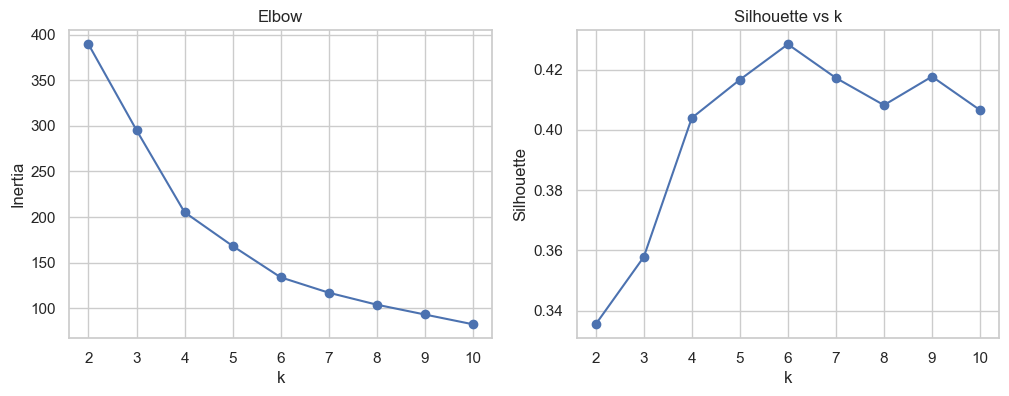

Best k by silhouette ≈ 6


In [18]:
# 6) Finding K using Elbow and Silhouette
inertias = []
sil_scores = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(list(K), inertias, marker='o')
ax[0].set_xlabel('k'); ax[0].set_ylabel('Inertia'); ax[0].set_title('Elbow')

ax[1].plot(list(K), sil_scores, marker='o')
ax[1].set_xlabel('k'); ax[1].set_ylabel('Silhouette'); ax[1].set_title('Silhouette vs k')
plt.show()

best_k = list(K)[int(np.argmax(sil_scores))]
print(f"Best k by silhouette ≈ {best_k}")


In [19]:
# 7) Train final K-Means with best_k
km_final = KMeans(n_clusters=best_k, n_init=10, random_state=42)
labels = km_final.fit_predict(X_scaled)

df_labeled = df.copy()
df_labeled['cluster'] = labels
df_labeled.head()


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,1,Male,19,15,39,4
1,2,Male,21,15,81,4
2,3,Female,20,16,6,5
3,4,Female,23,16,77,4
4,5,Female,31,17,40,5


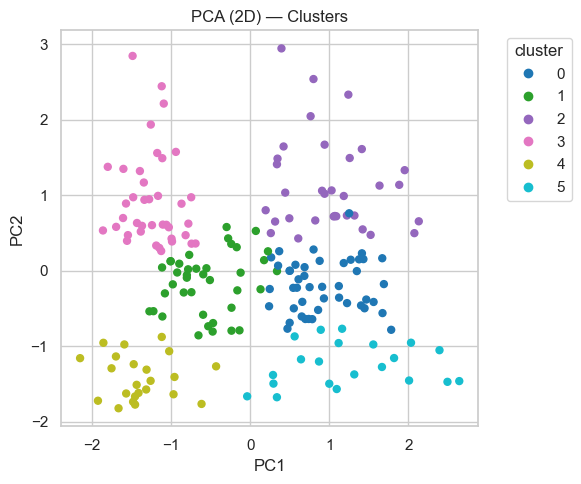

In [12]:
# 8) PCA 2D visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, s=25, cmap='tab10')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('PCA (2D) — Clusters')
plt.legend(*scatter.legend_elements(), title="cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout(); plt.show()


In [20]:
# 9) Simple cluster profiles
num_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
profile = df_labeled.groupby('cluster')[num_cols].mean().round(2)

# Gender distribution per cluster (if Gender exists)
if 'Gender' in df_labeled.columns:
    gender_counts = df_labeled.groupby('cluster')['Gender'].value_counts(normalize=True).rename('proportion').mul(100).round(1).reset_index()
    profile = profile.join(df_labeled.groupby('cluster').size().rename('count'))
    display(profile)
    display(gender_counts.pivot(index='cluster', columns='Gender', values='proportion').rename(columns={0:'Female_%',1:'Male_%'}))
else:
    profile = profile.join(df_labeled.groupby('cluster').size().rename('count'))
    display(profile)


,Age,Annual Income (k$),Spending Score (1-100),count
cluster,,,,
0,56.33,54.27,49.07,45
1,26.79,57.10,48.13,39
2,41.94,88.94,16.97,33
3,32.69,86.54,82.13,39
4,25.00,25.26,77.61,23
5,45.52,26.29,19.38,21


Gender,Female,Male
cluster,,
0,57.8,42.2
1,64.1,35.9
2,42.4,57.6
3,53.8,46.2
4,56.5,43.5
5,61.9,38.1


In [21]:
# 10) Save results
out_path = "clustered_customers.csv"  # saves next to the notebook when you download
df_labeled.to_csv(out_path, index=False)
print(f"Saved labeled data to {out_path}")


Saved labeled data to clustered_customers.csv
